In [ ]:
COME OUT WITH AOC MODEL 

In [20]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
import sklearn.feature_extraction.text 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
df = pd.read_csv('../project_3/CSV files/final_df.csv')

In [3]:
df.drop(columns ='Unnamed: 0', axis=1, inplace=True) #to drop unnamed column


In [4]:
print(df.shape)
df.info()

(19912, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19912 entries, 0 to 19911
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    19912 non-null  int64 
 1   clean_title  19892 non-null  object
dtypes: int64(1), object(1)
memory usage: 311.2+ KB


In [5]:
bool_series = pd.isnull(df["clean_title"]) 

In [6]:
df[bool_series] #shows nan values under "clean_title" column

,subreddit,clean_title
1812,1,NaN
2790,1,NaN
2935,1,NaN
3719,1,NaN
5906,1,NaN
7504,1,NaN
9052,1,NaN
10670,0,NaN
11315,0,NaN
12534,0,NaN


In [7]:
df.dropna(subset = ["clean_title"], inplace=True)

In [8]:
df.isna().sum()

subreddit      0
clean_title    0
dtype: int64

In [9]:
print(df.info()) #no more isna 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19892 entries, 0 to 19911
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    19892 non-null  int64 
 1   clean_title  19892 non-null  object
dtypes: int64(1), object(1)
memory usage: 466.2+ KB
None


## Earlier on, I shared that we will evaluate 2 models - Logistic Regression with TFIDF Vectorizer and Random Forest Classifier with TFIDF Vectorizer - and pick the best.

### Model Evaluation

In [11]:
# Define X and y
X = df['clean_title']
y = df['subreddit']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33, 
                                                    random_state=42)

In [12]:
# Define baseline accuracy
y.value_counts(normalize=True)

1    0.501106
0    0.498894
Name: subreddit, dtype: float64

### Random Forest - TFIDF Vectorizer

In [13]:
# Set up pipeline
pipe_rf_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1,2))),
    ('rf', RandomForestClassifier(criterion='gini'))
])

In [14]:
# Set up pipeline parameters with best parameters computed in notebook part 3
pipe_rf_t_params = {
    'rf__n_estimators': [200],
    'rf__max_depth': [None], 
    'rf__max_features': ['log2'],
    'rf__min_samples_split': [2]
}

In [15]:
# Set up a gridsearch
gs_rf_t = GridSearchCV(pipe_rf_t, pipe_rf_t_params, cv=5, verbose=1)

In [16]:
# Fit the gridsearch
gs_rf_t.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


#### Training Accuracy

In [17]:
# Score model on train data
gs_rf_t.score(X_train, y_train)

0.9582801830869663

#### Testing Accuracy

In [18]:
# Test data score
gs_rf_t.score(X_test, y_test)

0.9073876618431074

### Logistic Regression - TFIDF Vectorizer

In [22]:
# Transform X_train with TFIDFVectorizer
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=500)
Z_train = tvec.fit_transform(X_train)

# Instantiate and fit model
lr = LogisticRegression(solver='lbfgs', max_iter=5000)
lr.fit(Z_train, y_train)


LogisticRegression(max_iter=5000)

#### Training Accuracy

In [23]:
# Score model on train data
lr.score(Z_train, y_train)

0.9128836197193667

#### Testing Accuracy

In [24]:
# Transform X_test with TFIDFVectorizer
Z_test = tvec.transform(X_test)

In [26]:
# Score model on train data
lr.score(Z_test, y_test)

0.9047981721249048

In both models, one can observe overfit. However,the Random Forest Classifier is quite overfit and actually performs worse on test data than Logistic Regression. For this reason and for interpretability, we will use Logistic Regression for prediction, visualizations, and presentation.

### Explore and visualize Random Logistic Regression model

In [27]:
# Create dataframe with all corpus words and text frequency inverse document frequency score
Z_train_df = pd.DataFrame(data=Z_train.toarray(),
                          columns=tvec.get_feature_names())

In [30]:
# Look at 20 words (excluding dog and cat) that appear most often across some documents, but not all documents
# AKA likely best predictors of subreddit classification
Z_train_df.sum().sort_values(ascending=False).head(22)

dog       1226.924876
cat        848.019975
help       330.329568
puppi      210.649731
like       202.938988
love       202.147275
good       188.508922
need       186.566782
new        180.333920
old        177.630020
look       177.439068
littl      160.281477
advic      159.340791
breed      151.380673
kitten     146.450480
eat        139.276820
know       137.706632
think      136.828217
food       133.095855
kitti      131.738033
year       131.507766
day        128.026164
dtype: float64

- help is a neutral word? not able to distinguish between cat or dog

In [31]:
# Look at strength of each of top 10 of the 500 features in predicting either subreddit
# Negative correlations --> Cat ; Positive correlations --> Dog
features_500 = sorted(list(zip(lr.coef_[0], tvec.get_feature_names())))
features_500[:10] + features_500[-10:]

[(-10.040387884421738, 'cat'),
 (-5.534394838948374, 'kitten'),
 (-4.456473271492089, 'kitti'),
 (-2.5240556538644405, 'love'),
 (-2.4899328631765507, 'littl'),
 (-2.453826610230054, 'beauti'),
 (-2.3703052022708007, 'meet'),
 (-2.232500945603138, 'babi'),
 (-2.1485975836583235, 'boy'),
 (-2.101652988505418, 'pictur'),
 (2.4675610548290874, 'colli'),
 (2.55357393022383, 'rip'),
 (2.912665124663251, 'doggi'),
 (2.999905372956497, 'breed'),
 (3.1475369646887468, 'breeder'),
 (3.268035129849224, 'bark'),
 (3.3004336523041875, 'huski'),
 (4.399516307350813, 'pup'),
 (7.353424411758545, 'puppi'),
 (16.347585742647436, 'dog')]

In [68]:
features_500

[(-10.040387884421738, 'cat'),
 (-5.534394838948374, 'kitten'),
 (-4.456473271492089, 'kitti'),
 (-2.5240556538644405, 'love'),
 (-2.4899328631765507, 'littl'),
 (-2.453826610230054, 'beauti'),
 (-2.3703052022708007, 'meet'),
 (-2.232500945603138, 'babi'),
 (-2.1485975836583235, 'boy'),
 (-2.101652988505418, 'pictur'),
 (-2.042007261331029, 'nap'),
 (-1.8763214592651358, 'lil'),
 (-1.854918853771362, 'sleepi'),
 (-1.8465769346928316, 'face'),
 (-1.8377366433929387, 'brother'),
 (-1.8184244064996582, 'meow'),
 (-1.78595262570698, 'cute'),
 (-1.7516362356837707, 'halloween'),
 (-1.7256574212924538, 'morn'),
 (-1.7075044709099445, 'say'),
 (-1.6622155804545935, 'handsom'),
 (-1.6513154633106202, 'cuti'),
 (-1.5755229215416875, 'man'),
 (-1.567416723635118, 'ago'),
 (-1.5309918236753286, 'hello'),
 (-1.5264988096584613, 'sit'),
 (-1.496607783718543, 'guess'),
 (-1.4903876878602318, 'pretti'),
 (-1.4874113148730377, 'turn'),
 (-1.4579725760319298, 'alway'),
 (-1.4566748984853963, 'like'),
 

In [69]:
# Make a dataframe of top 20 strongest predictors for Cats
cat_feats_list = []

for x,y in features_500[:21]:
    feat = {}
    feat['feature'] = y
    feat['coefficient'] = x
    cat_feats_list.append(feat)

cat_feats_df = pd.DataFrame(cat_feats_list)
print(cat_feats_df.shape)
cat_feats_df.head(21)

(21, 2)


,feature,coefficient
0,cat,-10.040388
1,kitten,-5.534395
2,kitti,-4.456473
3,love,-2.524056
4,littl,-2.489933
5,beauti,-2.453827
6,meet,-2.370305
7,babi,-2.232501
8,boy,-2.148598
9,pictur,-2.101653


In [74]:
# Make a dataframe of top 20 strongest predictors for Dogs
dog_feats_list = []

for x,y in features_500[:-23:-1]:
    feat = {}
    feat['feature'] = y
    feat['coefficient'] = x
    dog_feats_list.append(feat)

dog_feats_df = pd.DataFrame(dog_feats_list)
print(dog_feats_df.shape)
dog_feats_df.head(30)

(22, 2)


,feature,coefficient
0,dog,16.347586
1,puppi,7.353424
2,pup,4.399516
3,huski,3.300434
4,bark,3.268035
5,breeder,3.147537
6,breed,2.999905
7,doggi,2.912665
8,rip,2.553574
9,colli,2.467561


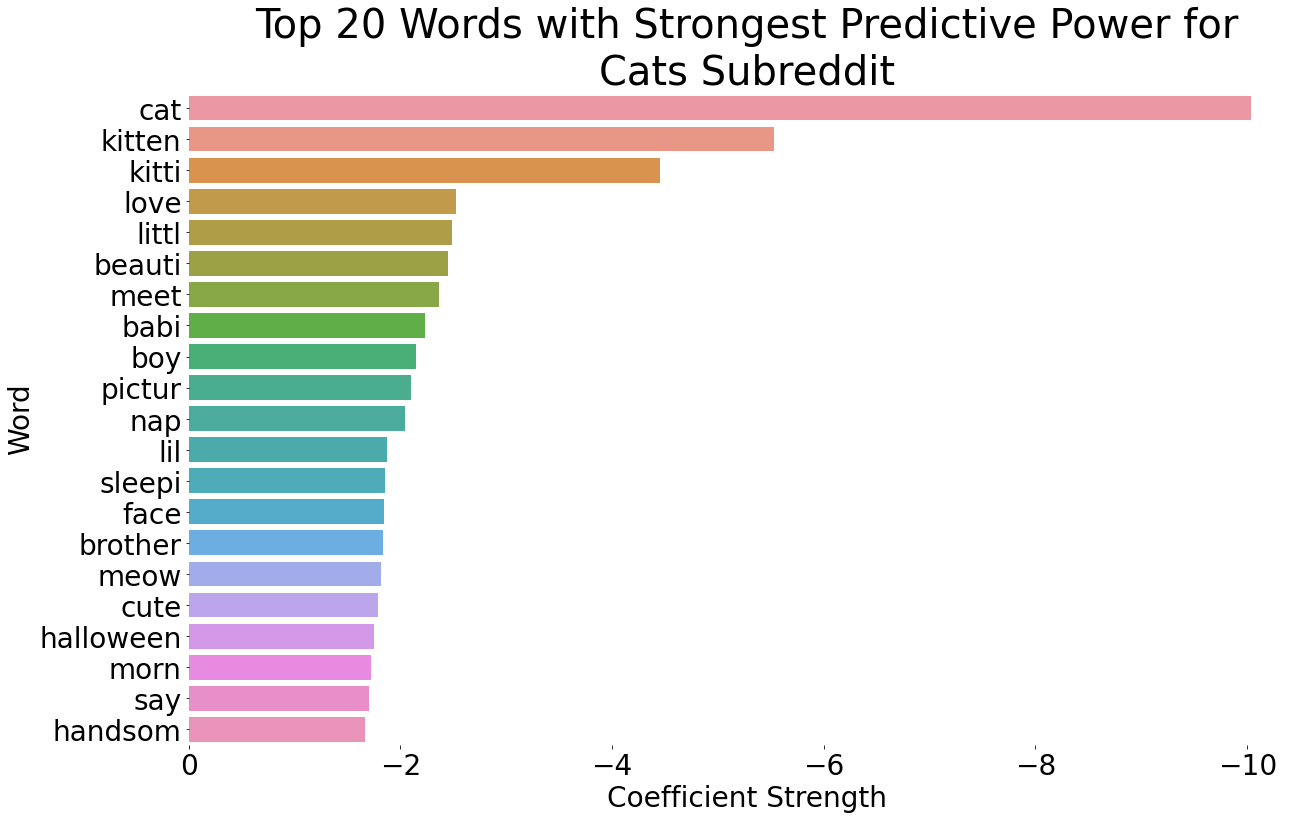

In [77]:
# Plot the top predictors for Cats
plt.figure(figsize=(20,12))
sns.barplot(data=cat_feats_df, x='coefficient', y='feature').invert_xaxis()
plt.xlabel('Coefficient Strength', size=28)
plt.ylabel('Word', size=28)
plt.yticks(size=28)
plt.xticks(size=28)
plt.title('Top 20 Words with Strongest Predictive Power for\nCats Subreddit', size=40)
sns.despine(left=True, bottom=True);

- Seems like cat owners appreciate aesthetically pleasing photos/looks of their own/other cats, given words such as 'cute', 'sleeping', 'little', kitten' and 'beautiful'.
- I noticed that the first 3 words are all kitten/cat related, which shows I could have cleaned the data a bit better. Otherwise, it seems to indicate that there are many titles/posts on kittens. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


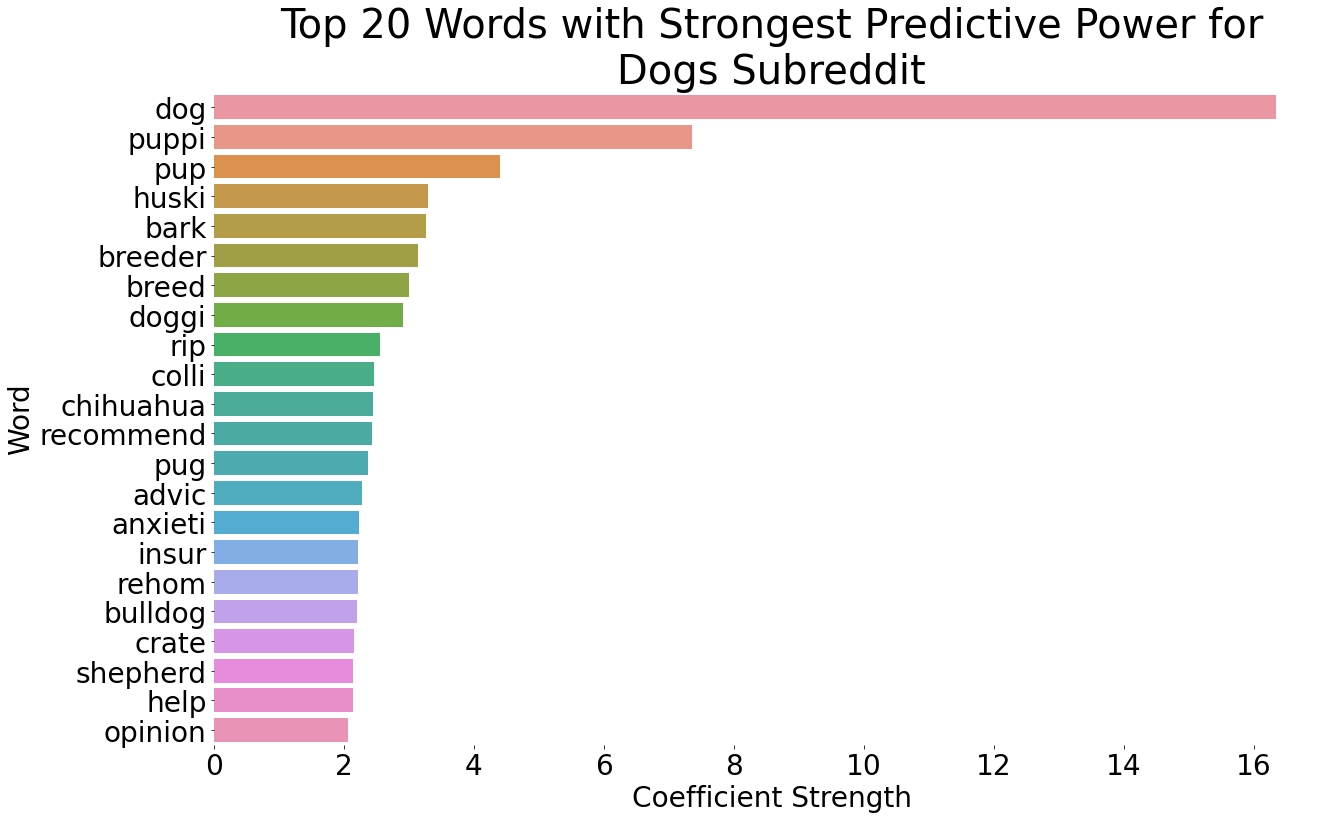

In [78]:
# Plot the top 20 predictors for Dogs
plt.figure(figsize=(20,12))
sns.barplot(dog_feats_df['coefficient'], dog_feats_df['feature'])
plt.xlabel('Coefficient Strength', size=28)
plt.ylabel('Word', size=28)
plt.yticks(size=28)
plt.xticks(size=28)
plt.title('Top 20 Words with Strongest Predictive Power for\nDogs Subreddit', size=40)
sns.despine(left=True, bottom=True);

- Similar to cats, I could have cleaned the words 'pup', 'puppi' as it is merely duplicates. However, seems dog owners love to post on their puppies as well. 
- Unlike the vibe from the cats Subreddit, dog owners seem to discuss mainly dog breeds (e.g. 'breeder', 'chihuahua', 'bulldog', 'pug') as well as seek advice/help (based on words e.g.'advice', 'anxieti', 'recommend','help', 'opinion', 'insur'). Dog owners seem more practical?

In [79]:
# Get probability for 'subreddit' == 'cat'
probs = lr.predict_proba(Z_test)[:, 0]
probs[:10]

array([0.20137316, 0.351333  , 0.60699954, 0.9952296 , 0.54713434,
       0.66450706, 0.84209274, 0.01949283, 0.02103517, 0.00435266])

In [80]:
# Get predictions
preds = lr.predict(Z_test)
preds[:10]

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1])

In [81]:
# Zip probs / preds / actuals
probs_preds_actual = list(zip(probs, preds, y_test))
probs_preds_actual[:10]

[(0.20137316171542852, 1, 1),
 (0.3513329957712408, 1, 1),
 (0.6069995384805743, 0, 0),
 (0.9952295995286043, 0, 0),
 (0.547134343348074, 0, 0),
 (0.6645070551774954, 0, 1),
 (0.8420927407645449, 0, 0),
 (0.019492826364218674, 1, 1),
 (0.02103517393127785, 1, 1),
 (0.004352659314695417, 1, 1)]

In [85]:
# Generate confusion matrix
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [86]:
# Create labeled dataframe from confusion matrix
# Code adapted from lesson 4.03-lesson-classification_metrics_i by Matt Brems & Riley Dallas
cm_df = pd.DataFrame(cm, 
             columns=['Predicted Cats', 'Predicted Dogs'], 
             index=['Actual Cats', 'Actual Dogs'])
cm_df

,Predicted Cats,Predicted Dogs
Actual Cats,3083,161
Actual Dogs,464,2857


In [91]:
print("\nAccuracy: ", (tn + tp) / (tn + fp + fn + tp))
print("Sensitivity: ", tp / (tp + fn))
print("Specificity: ", tn / (tn + fp))
print("Precision: ", tp / (tp + fp))
print("Misclassification rate: ",  (fp + fn) / (tn + fp + fn + tp))


Accuracy:  0.9047981721249048
Sensitivity:  0.8602830472749172
Specificity:  0.9503699136868065
Precision:  0.9466534128561962
Misclassification rate:  0.09520182787509521


### Recommendations and Conclusions 
- For modeling rigor, literal subreddit name references should have been removed as individual words (e.g. "dog", "cat") were left in earlier on. 
- Perhaps this project could be improved by performing a form of sentiment analysis on the data in future studies. Lastly, though this model scored only around ~ 90% accuracy on testing data, this model still predicts much better than the baseline (~ 50.6%) and might be helpful in differentiating between dogs and cats. 